# Setup

 Import standard modules

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
import scipy
from time import perf_counter

Find project root, append to path, and define wdir for data

In [2]:
import os
os.chdir('/home/chris/projects/tidal_flat_0d')

In [3]:
from pyprojroot import here
root = here()
sys.path.append(str(root))
wdir = root / "data" / "interim"

Import project modules from src folder

In [4]:
from src import features

In [5]:
tides = features.load_tide(wdir, "tides.feather")
tides = tides - (np.mean(tides) + 0.6)

In [184]:
from src import models
runs = 1
slr = 0

sim = models.Simulation(
    tide_elev=tide_elev,
    init_land_elev=init_land_elev,
    index=index,
    init_conc=init_conc,
    bound_conc=bound_conc,
    grain_dia=grain_dia,
    grain_dens=grain_dens,
    bulk_dens=bulk_dens,
    org_rate=org_rate,
    comp_rate=comp_rate,
    sub_rate=sub_rate,
    slr=slr,
    runs=runs,
)
sim.simulate()

Aggradation:           6.85e-02 m
Degradation:           -6.69e-03 m
Elevation change:      6.27e-02 m
Final elevation:       1.0627 m
Runtime:               00:04:56


<AxesSubplot:>

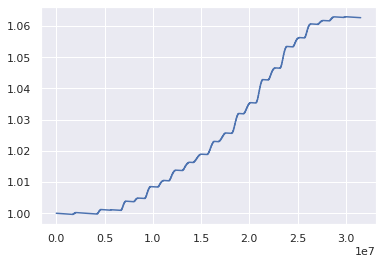

In [199]:
sim.results.data.land_elev.plot()

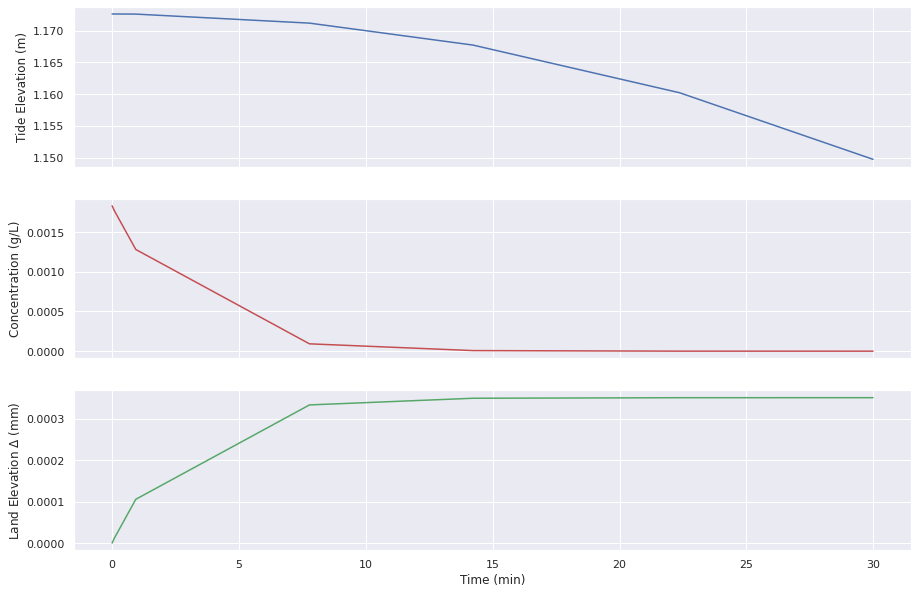

In [202]:
sim.inundations[2].result.ebb.plot()

In [374]:
dt = np.diff(I.result.flood.t)
ws = I.settle_rate
depth = I.result.flood.y[0] - I.result.flood.y[2]
conc = I.result.flood.y[1]

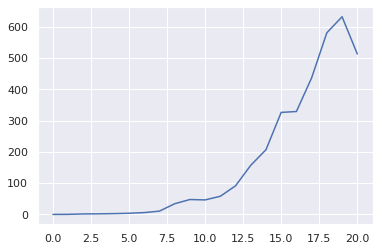

In [381]:
plt.plot(dt)

In [382]:
dt

array([1.85200009e-02, 1.85200009e-01, 1.58218168e+00, 1.85944646e+00,
       2.61845284e+00, 3.71743976e+00, 5.81895930e+00, 1.05338052e+01,
       3.41296785e+01, 4.76144046e+01, 4.63829045e+01, 5.80203655e+01,
       9.13813199e+01, 1.57048844e+02, 2.06701789e+02, 3.25977723e+02,
       3.28866232e+02, 4.36423723e+02, 5.80480691e+02, 6.31682419e+02,
       5.12955901e+02])

In [377]:
dt * ws * conc[:-1] <= depth[:-1] * conc[:-1]

array([ True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

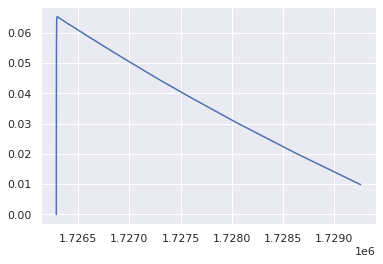

In [386]:
plt.plot(I.result.flood.t[:-1], conc[:-1])

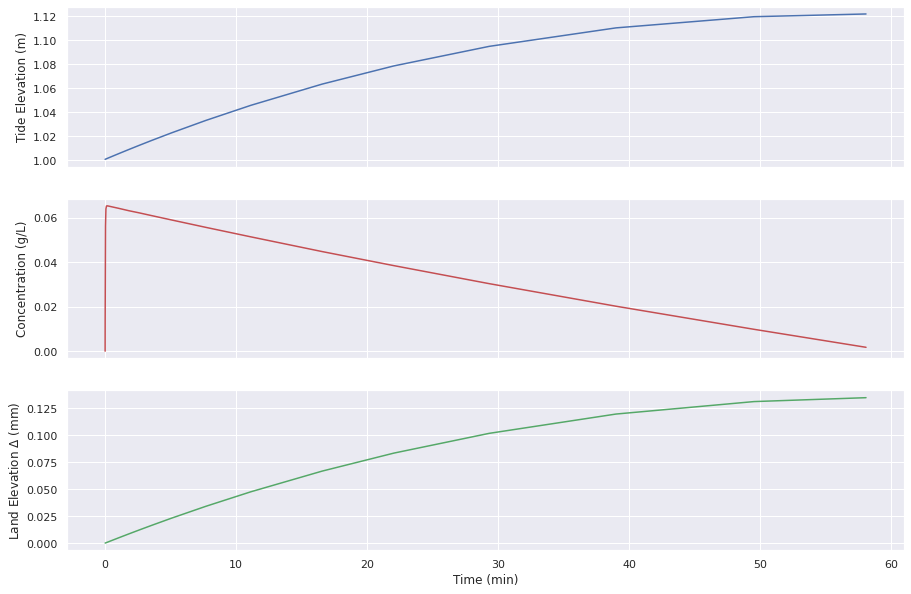

In [387]:
I.result.flood.plot()

In [189]:
from scipy.integrate import solve_ivp
global g_time, g_y
g_time = np.empty(0)
g_y = np.empty(0)
g_dydt = np.empty(0)
def exponential_decay(t, y):
    global g_time, g_y, g_dydt
    g_time = np.append(g_time, t)
    g_y = np.append(g_y, y[0])
    return -0.5 * y
sol = solve_ivp(exponential_decay, [0, 10], [2])
y = sol.y[0]
t_diff = np.diff(sol.t)
dydt = -0.5 *y[0:-1] * t_diff
y2 = np.insert(y[:-1] + dydt, 0, y[0])

In [359]:
def aggrade_rk(t, y, limb, dZdt_func, bound_conc, settle_rate, bulk_dens):

    # set values for concentration and elevation
    tide_elev = y[0]
    conc = y[1]
    land_elev = y[2]

    # use spline function for tide height to set current water_height
    depth = tide_elev - land_elev  # calculate current depth

    # use derivative of tide spline to get current gradient and set H
    dZdt = dZdt_func(t)

    if limb=='flood':
        dCdt = - (settle_rate * conc) / depth - 1 / depth * (conc - bound_conc) * dZdt
    elif limb=='ebb':
        dCdt = - (settle_rate * conc) / depth

    dEdt = settle_rate * conc / bulk_dens

    return [dZdt, dCdt, dEdt]

def aggrade_fd(index, tide_elev, init_land_elev, bound_conc, settle_rate, bulk_dens,):
    land_elev = np.array([init_land_elev])
    conc = np.array([0])
    depth = np.array([0.0001])
    for i in index:
        depth = np.append(depth, tide_elev[i] - land_elev[i])
        delta_conc = - settle_rate * conc[i] / depth[i] - 1 / depth[i] * (conc[i] - bound_conc) * (depth[i] - depth[i-1])
        conc = np.append(conc, conc[i-1] + delta_conc)
        delta_land_elev = settle_rate * conc[i] / bulk_dens
        land_elev = np.append(land_elev, land_elev[i-1] + delta_land_elev)
        
    return np.stack((depth, conc, land_elev))

inundation = sim.inundations[0]
limb = 'flood'
dZdt_func = inundation.tide_spline_deriv
bound_conc = inundation.bound_conc
settle_rate = inundation.settle_rate
bulk_dens = inundation.bulk_dens
start = inundation.start
slack = inundation.slack_time
end = inundation.end
tide_elev_start = inundation.tide_elev[0]
tide_elev = inundation.tide_elev
init_land_elev = inundation.init_land_elev

The solver successfully reached the end of the integration interval.


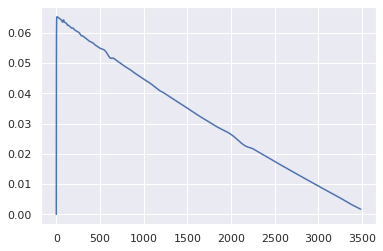

In [309]:
a = tide_elev_start - 1e-3
sol = solve_ivp(fun=aggrade_rk,t_span=[start, slack],y0=[tide_elev_start, 0, a],method="DOP853",args=("flood",dZdt_func,bound_conc,settle_rate,bulk_dens,),dense_output=True)
t = np.linspace(start, slack, (slack-start))
print(sol.message)
plt.plot(sol.sol(t)[1])

In [360]:
dt = 1
index = np.arange(0, slack-start+1, dt)
fd_sol = aggrade_fd(index=index, tide_elev=tide_elev, init_land_elev=init_land_elev, bound_conc=bound_conc, settle_rate=settle_rate, bulk_dens=bulk_dens)

<ipython-input-359-93355a9a03a8>:30: RuntimeWarning: overflow encountered in double_scalars
  conc = np.append(conc, conc[i-1] + delta_conc)
<ipython-input-359-93355a9a03a8>:29: RuntimeWarning: invalid value encountered in double_scalars
  delta_conc = - settle_rate * conc[i] / depth[i] - 1 / depth[i] * (conc[i] - bound_conc) * (depth[i] - depth[i-1])


In [365]:
fd_sol[1]

array([ 0.        , -9.10360166, 19.01901069, ...,         nan,
               nan,         nan])

In [319]:
inundation.slack_time - inundation.start

3484

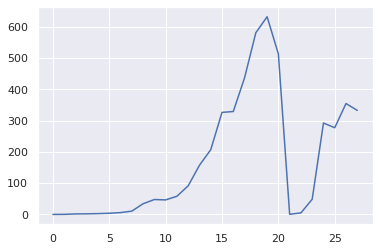

In [366]:
plt.plot(np.diff(inundation.result.time))